# 3 Parameter estimation

This notebook introduces the `Estimator` class and demonstrates it's functions for parameter estimation using the example of a simple batch model (see Notebook [1. Modeling & Simulation](1.%20Modeling%20&%20Simulation.ipynb)).

In [1]:
from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator, generalized_islands
import pandas as pd
import pygmo

## 3.1 Load the `SimpleBatch` FMU model

In [2]:
SimpleBatchModel = FmuModel(path=r'../../../tests/test_data/SimpleBatch.fmu')
print(f"Model parameters: \n {SimpleBatchModel.parameters}")
print(f"Model observables: \n {SimpleBatchModel.observables}")

Model parameters: 
 {'Ks': 0.01, 'S0': 10.0, 'X0': 0.2, 'Y_XS': 0.35, 'mu_max': 0.4}
Model observables: 
 ['S', 'X', 'der(S)', 'der(X)', 'mu']


## 3.2 Load experimental data & data structure setup
In order to setup an `Experiment` data structure (see [Notebook 2](2.%20Experimental%20data%20and%20error%20modeling.ipynb)), raw measurement data is loaded first. Here, the function `pandas.read_excel` is used to read the contents of an Excel sheet _SimpleBatch_Data.xlsx_, which contains artificial measurements for biomass concentration `X` $[g \cdot L^{-1}]$ and substrate concentration `S` $[g \cdot L^{-1}]$ over the duration of a batch cultivation.

In [3]:
# import datasheet
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0, header=(0,1))
data.head(11)

Time,X,S
h,g/L,g/L
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
0.5,0.268477,NaN
0.6,0.312500,NaN
0.7,0.150687,NaN
0.8,0.226870,NaN


Before creating an `Experiment` object by passing the created `DataFrame`, the multi-index must be removed. 

For this simple example, the `Experiment`'s default `LinearErrorModel` is used to describe the `Measurement` noise (see Notebook [2. Experimental data and error modeling](2.%20Experimental%20data%20and%20error%20modeling.ipynb)). As the names of the columns in `data` directly correspond to the states in `SimpleBatchModel.observables` no `observation_mapping` must be defined.

In [4]:
# drop the multi-index header and show resulting dataframe
data.columns = data.columns.droplevel(1)
display(data)

# create an Experiment object
experiment = datatypes.Experiment(data) 

Time,X,S
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
...,...,...
9.6,4.885956,NaN
9.7,4.807351,NaN
9.8,5.167874,NaN
9.9,5.220779,NaN


To compare the unfitted model's precitions to experimental data, the `plot_simulation` function of the `visualization` submodule takes the keyword argument _experiment_.

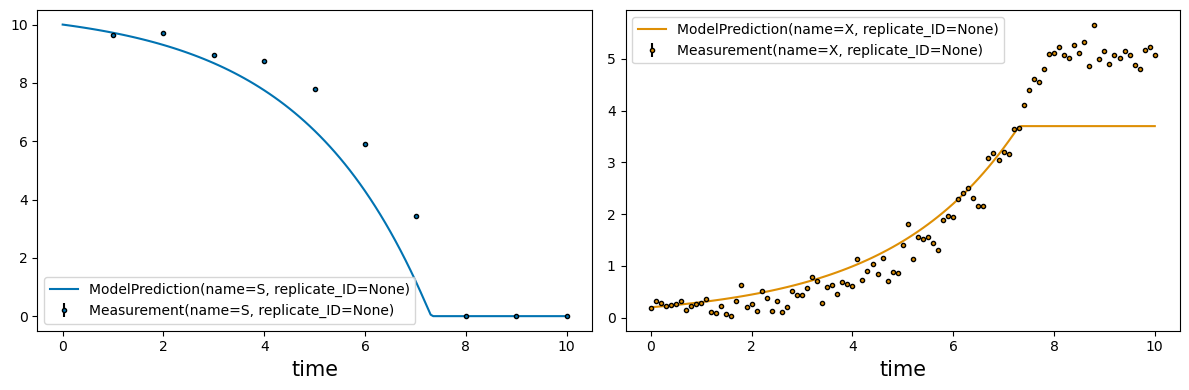

In [5]:
# compare simulation to data
simulation = SimpleBatchModel.simulate(t0=0, t_end=10, stepsize=0.1)
_ = visualization.plot_simulation(simulation=simulation, experiment=experiment, observe=['S', 'X'])

## 3.3 Problem definition
Besides a model for forward simulation and experimental data, an estimation problem is defined by unknown parameters and and their bounds using a `dictionary`. 

In [6]:
# define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

## 3.4 The `Estimator` class

The `Estimator` class collects all single parts of a problem defined by the user and manages the processes of model fitting. Creating an instance of this class requires the following arguments:

| Argument | Type | Description |
|----------|------|-------------|
| model | models.Estim8Model | The model class to be fitted. Must be a subclass of Estim8Model that runs the simulations. |
| bounds | dict[str, List[float]] | Dictionary defining the parameter bounds for estimation. Format: {"param_name": [lower_bound, upper_bound]}. |
| data | Experiment \| Dict[str, Experiment] | Experimental data for model fitting. Can be single experiment or multiple replicates as Experiment objects in form of dict{replicate_ID: Experiment}.|

Optional keyword arguments are:

| Kwarg | Type | Description |
|----------|------|-------------|
| t | List[float], optional | Time vector specification as [t_0, t_end, step_size]. If None, will be automatically determined from the experimental data |
| metric | Literal["SS", "WSS", "negLL"], optional | Loss function for optimization: "SS" (Sum of squared residuals), "WSS" (Weighted sum of squared residuals), or "negLL" (Negative log-likelihood). Default is "SS" |
| parameter_mapping | List[ParameterMapper] \| ParameterMapping, optional | Defines parameter relationships between replicates. Can be list of mappings or complete ParameterMapping object. None means all parameters are applied to all model replicates (default) |

In [7]:
# Instantiating an Estimator object
estimator = Estimator(
    model=SimpleBatchModel,     # model used for simulation
    bounds=bounds,              # unknown parameters and bounds
    data=experiment,            # experimental data
    t=[0, 10, 0.1],             # the timeframe for model simulation as [t_0, t_end, step_size],
    metric = 'SS'               # default objective function Sum of squared residuals
)

`Estim8` supports a variety of optimzation algorithms from [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html), [`scikit-optimize`](https://scikit-optimize.github.io/stable/) and [`pygmo`](https://esa.github.io/pygmo2/index.html). Is is higly recommended to check out their documentations, e.g. for the use of solver hyperparameters and keyword arguments. 

The optimization algorithm of choice is specified by passing a corresponding method key to the function `Estimator.estimate`. 

### 3.4.1 scipy and scikit-optimize alogorithms and keys: 

| Method key         | Optimization function          | Solver parallelization |
|-----------------|-----------------------------------|------------------------|
| local           | [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)         | ❌                  |
| de              | [`scipy.optimize.differential_evolution`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) | ✅               |
| bh              | [`scipy.optimize.basinhopping`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html)     |❌                  |
| shgo            | [`scipy.optimize.shgo`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html)             |✅               |
| dual_annealing  | [`scipy.optimize.dual_annealing`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html)   |❌                  |
| gp              | [`skopt.gp_minimize`](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)               |✅               |


In this example, the `differential_evolution` function from `scipy`.optimize is used to solve the estimation problem.
 
The estimation is started by calling the function `Estimator.estimate`. It takes at least the following arguments:

| Argument | Type | Description |
|----------|------|-------------|
| method   | str or List[str] | the method key of the optimization algorithm. Pygmo algorithms are passed as a List[str] (see below). |
| max_iter | int  | maximum iteration rounds for the solver algorithm |

Additionally, keyword arguments include:

| Kwarg | Type | Description |
|----------|------|-------------|
| n_jobs   | int | number of parallel jobs to run the optimization algorithm with. |
| optimizer_kwargs | dict  | keyword arguments for the optimization function |

Finally, the `Estimator.estimate` method returns the estimated parameters and an info-object containing additional information about the optimization procedure. 

In [8]:
estimates, info = estimator.estimate(
    method              =   'de',           # method key of the optimization algorithm
    max_iter            =   1000,           # maximum number of iterations for the solver
    n_jobs              =   1,              # process pool size of the solver algorithm     
    optimizer_kwargs    =   {               # kewyword arguments to pass to the differential_evolution function:
                'disp': True,               # prints the evolution process
                "x0": [0.15, 0.3, 0.4],     # initial guess for the unknown parameters
                "popsize": 15,              # population size
            }
)

print(f" \nEstimated parameters: \n{estimates}")
print(f"Estimation info: \n{info}")

differential_evolution step 1: f(x)= 5.187519893589525
differential_evolution step 2: f(x)= 5.187519893589525
differential_evolution step 3: f(x)= 5.187519893589525
differential_evolution step 4: f(x)= 5.187519893589525
differential_evolution step 5: f(x)= 5.187519893589525
differential_evolution step 6: f(x)= 4.66017492209449
differential_evolution step 7: f(x)= 4.66017492209449
differential_evolution step 8: f(x)= 4.66017492209449
differential_evolution step 9: f(x)= 4.66017492209449
differential_evolution step 10: f(x)= 4.526663410674368
differential_evolution step 11: f(x)= 4.376752316743263
differential_evolution step 12: f(x)= 3.888030711038112
differential_evolution step 13: f(x)= 3.888030711038112
differential_evolution step 14: f(x)= 3.888030711038112
differential_evolution step 15: f(x)= 3.8872908160179627
differential_evolution step 16: f(x)= 3.8872908160179627
differential_evolution step 17: f(x)= 3.8872908160179627
differential_evolution step 18: f(x)= 3.8618782707797235
d

### 3.4.2 Visualizing estimation results

To inspect the optimization results the `plot_estimates` function from the `visualization` submodule is used:

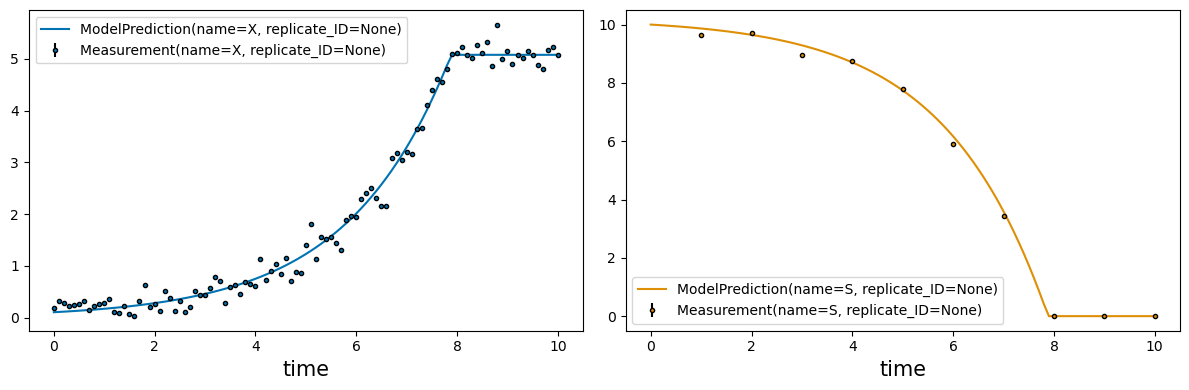

In [9]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)

### 3.4.3 Parallelized parameter estimation

In many cases the parameter estimation time can be reduced by parallelizing the optimization function using multiple CPUs. In this example, 4 parallel jobs are used for the differential evolution algorithm by setting `n_jobs=4` when calling the `estimate` function:

In [10]:
estimates, info = estimator.estimate(
    method              =   'de',           # method key of the optimization algorithm
    max_iter            =   1000,           # maximum number of iterations for the solver
    n_jobs              =   4,              # process pool size of the solver algorithm     
    optimizer_kwargs    =   {               # kewyword arguments to pass to the differential_evolution function:
                'disp': True,               # prints the evolution process
                "x0": [0.15, 0.3, 0.4],     # initial guess for the unknown parameters in the same order as unknowns
                "popsize": 15,              # population size
            }
)

c:\Users\Tobia\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 28.605241567077343
differential_evolution step 2: f(x)= 22.78821992617205
differential_evolution step 3: f(x)= 10.065425007814639
differential_evolution step 4: f(x)= 6.433987917222236
differential_evolution step 5: f(x)= 4.4973053733108
differential_evolution step 6: f(x)= 4.182347539947269
differential_evolution step 7: f(x)= 4.182347539947269
differential_evolution step 8: f(x)= 4.182347539947269
differential_evolution step 9: f(x)= 4.182347539947269
differential_evolution step 10: f(x)= 4.104307101346693
differential_evolution step 11: f(x)= 4.059027522127302
differential_evolution step 12: f(x)= 3.8602607304329655
differential_evolution step 13: f(x)= 3.8602607304329655
differential_evolution step 14: f(x)= 3.8602607304329655
differential_evolution step 15: f(x)= 3.8602607304329655
differential_evolution step 16: f(x)= 3.8602607304329655
differential_evolution step 17: f(x)= 3.8593992688392422
differential_evolution step 18: f(x)= 3.85004224735

### 3.4.4 Advanced parameter estimation with `pygmo`

`pygmo` is a scientific Python library for massively parallel optimization, implementing a range of state-of-the-art bio-inspired and evolutionary algorithms. Using the [asynchronous, generalized islands model](generalizedIslandsref), these algorithms can be easily mixed via a [topology](https://esa.github.io/pygmo2/topology.html), yielding a "super algorithm" that exploits algorithmic cooperation. `estim8` features the following algorithms: 

| method key                | algorithm                                         |
|------------------------|-----------------------------------------------------|
| [scipy_optimize](https://esa.github.io/pygmo2/algorithms.html#pygmo.scipy_optimize)          | A wrapper around `scipy.optimize.minimize`          |
| [de1220](https://esa.github.io/pygmo2/algorithms.html#pygmo.de1220)                 | Self-adaptive Differential Evolution, pygmo flavour (pDE) |
| [bee_colony](https://esa.github.io/pygmo2/algorithms.html#pygmo.bee_colony)             | Artificial Bee Colony                               |
| [gaco](https://esa.github.io/pygmo2/algorithms.html#pygmo.gaco)                   | Extended Ant Colony Optimization algorithm          |
| [pso](https://esa.github.io/pygmo2/algorithms.html#pygmo.pso)                    | Particle Swarm Optimization                         |
| [sga](https://esa.github.io/pygmo2/algorithms.html#pygmo.sga)                    | A Simple Genetic Algorithm                          |
| [sea](https://esa.github.io/pygmo2/algorithms.html#pygmo.sea)                    | (N+1)-ES simple evolutionary algorithm              |
| [compass_search](https://esa.github.io/pygmo2/algorithms.html#pygmo.compass_search)          | Compass Search                                      |
| [gwo](https://esa.github.io/pygmo2/algorithms.html#pygmo.gwo)                    | Grey Wolf Optimizer (gwo)                           |
| [cmaes](https://esa.github.io/pygmo2/algorithms.html#pygmo.cmaes)                  | Covariance Matrix Evolutionary Strategy (CMA-ES)     |
| [simulated_annealing](https://esa.github.io/pygmo2/algorithms.html#pygmo.simulated_annealing)     | Simulated Annealing (Corana’s version)              |
| [nsga2](https://esa.github.io/pygmo2/algorithms.html#pygmo.nsga2)                  | Non dominated Sorting Genetic Algorithm (NSGA-II)    |
| [mbh](https://esa.github.io/pygmo2/algorithms.html#pygmo.mbh)                    | Monotonic Basin Hopping (generalized)               |
| [ihs](https://esa.github.io/pygmo2/algorithms.html#pygmo.ihs)                    | Improved harmony search algorithm                   |
| [xnes](https://esa.github.io/pygmo2/algorithms.html#pygmo.xnes)                   | Exponential Evolution Strategies                    |
| [de](https://esa.github.io/pygmo2/algorithms.html#pygmo.de)                     | Differential Evolution                              |

For using `pygmo`'s Generalized Islands approach, the `estimate` function is called with a `list` of algorithms keys in the `method` argument. 
A list of implemented topologies can be found [here](https://esa.github.io/pygmo2/topologies.html).


[generalizedIslandsref]:https://link.springer.com/chapter/10.1007/978-3-642-28789-3_7



In [11]:
# algorithms for islands in heterogenous archipelago and keyword arguments (see pygmo documentation for more details)
algorithms_and_kwargs = {
    'sga'   : dict(gen=10, cr=.90, eta_c=1., m=0.02, param_m=1., param_s=2, crossover='exponential', mutation='polynomial', selection='tournament', seed=42),
    'pso'   : dict(gen=10, omega=0.7298, eta1=2.05, eta2=2.05, max_vel=0.5, variant=5, neighb_type=2, neighb_param=4, memory=False, seed=42),
    'de1220': dict(gen=10, allowed_variants=[2, 3, 7, 10, 13, 14, 15, 16], variant_adptv=1, ftol=1e-6, xtol=1e-6, memory=False, seed=42),
    'sea'   : {}    # here we use the default kwargs listed above
    }

# print the default algorithm kwargs for pygmo.sea algorithm
print(f"Default kwargs for pygmo.sea: {generalized_islands.PygmoHelpers.algo_default_kwargs['sea']} \n")


estimates_1, info_1 = estimator.estimate(   
    method = list(algorithms_and_kwargs.keys()),                # a list of algorithm keys defined above
    n_jobs=6,                                                   # process pool size of the solver algorithm
    max_iter=5,                                                # number of evolutions
    optimizer_kwargs = {
        'pop_size'      :   30,                                     # population size of each island
        'algos_kwargs'  :   list(algorithms_and_kwargs.values()),   # algorithm kwargs
        'topology'      :   pygmo.fully_connected(),                           # the archipelagos topology, default is pygmo.fully_connected()
        'report'        :   2                                       # prints out progress during evolutions and collects a trace of each island champion per evolution
    }
)

Default kwargs for pygmo.sea: {'gen': 40} 

>>> Created Island 1 using <pygmo.core.sga object at 0x000001B07CCC4330>
>>> Created Island 2 using <pygmo.core.pso object at 0x000001B07CC911B0>
>>> Created Island 3 using <pygmo.core.de1220 object at 0x000001B07CCC2C30>
>>> Created Island 4 using <pygmo.core.sea object at 0x000001B07CC74D30>


2025-07-17 14:32:53,404 - estim8.generalized_islands - INFO - ## Evolution 1 of island 1857519952432 completed:
      Algorithm: SEA: (N+1)-EA Simple Evolutionary Algorithm
      Champion loss: 9.05e+00
2025-07-17 14:33:00,228 - estim8.generalized_islands - INFO - ## Evolution 2 of island 1857519952432 completed:
      Algorithm: SEA: (N+1)-EA Simple Evolutionary Algorithm
      Champion loss: 4.58e+00
2025-07-17 14:33:00,645 - estim8.generalized_islands - INFO - ## Evolution 1 of island 1857519949888 completed:
      Algorithm: PSO: Particle Swarm Optimization
      Champion loss: 4.04e+00
2025-07-17 14:33:00,968 - estim8.generalized_islands - INFO - ## Evolution 1 of island 1857519944368 completed:
      Algorithm: SGA: Genetic Algorithm
      Champion loss: 6.60e+00
2025-07-17 14:33:01,086 - estim8.generalized_islands - INFO - ## Evolution 1 of island 1857519951424 completed:
      Algorithm: sa-DE1220: Self-adaptive Differential Evolution 1220
      Champion loss: 4.33e+00
2025-07-

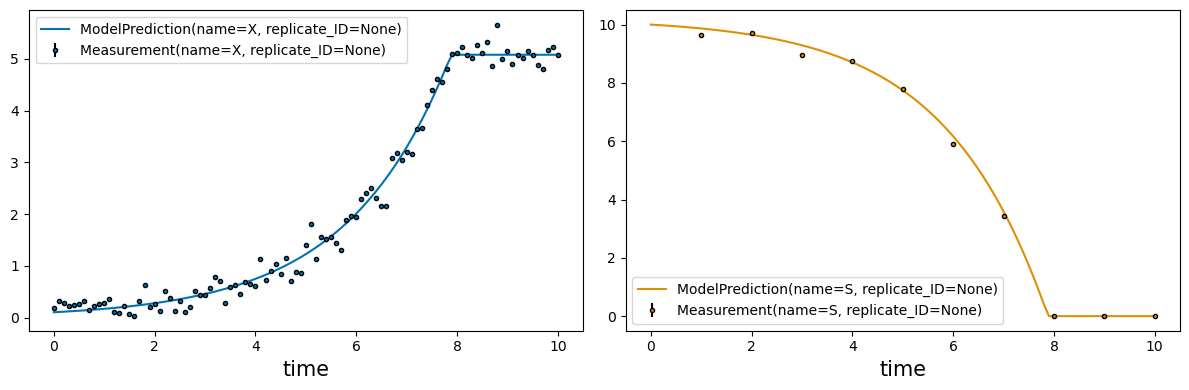

In [12]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)

When calling the `estimate` function with `report>=1`, the `info` object provides an attribute `evo_trace` which is a `pandas.DataFrame` with data about the archipelago's evolutions. This is usefull e.g. when comparing the performance of different algorithms or the archipelago's topology setup. 

In the following example a second approach using the same algorithms but fully unconnected islands (`topology: pygmo.fully_connected()`) is used for optimization. The evolution traces of both approaches are then compared: 

In [13]:
# 2. Archipelago optimization with unconnected islands
estimates_2, info_2 = estimator.estimate(   
    method = list(algorithms_and_kwargs.keys()),                # a list of algorithm keys defined above
    n_jobs=6,                                                   # process pool size of the solver algorithm
    max_iter=5,                                                # number of evolutions
    optimizer_kwargs = {
        'pop_size'      :   30,                                     # population size of each island
        'algos_kwargs'  :   list(algorithms_and_kwargs.values()),   # algorithm kwargs
        'topology'      :   pygmo.unconnected(),                    # run with unconnected islands
        'report'        :   1                                       # collects a trace of each island champion per evolution
    }
)


>>> Created Island 1 using <pygmo.core.sga object at 0x000001B07C894270>
>>> Created Island 2 using <pygmo.core.pso object at 0x000001B07CCE9930>
>>> Created Island 3 using <pygmo.core.de1220 object at 0x000001B07CCEAEF0>
>>> Created Island 4 using <pygmo.core.sea object at 0x000001B07CCEADF0>


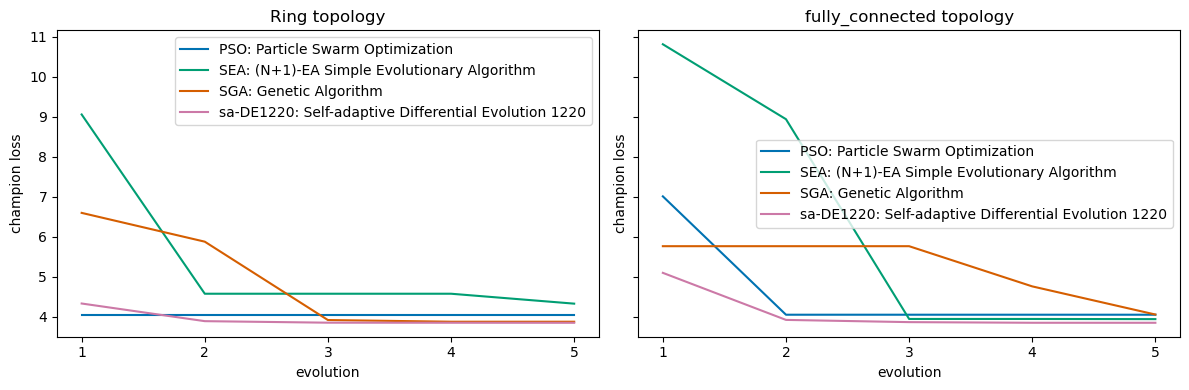

In [14]:
# plot the evolution traces of both approaches
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, info in zip(axes, [info_1, info_2]):
    islands_traces = info.evo_trace.groupby("algorithm")
    for group in islands_traces.groups:
        data = islands_traces.get_group(group)
        ax.plot(data.index.get_level_values("evolution"), data["champion_loss"], label=group)

    ax.set_xlabel("evolution")
    ax.set_ylabel("champion loss")
    ax.set_xticks(data.index.get_level_values("evolution"))
    ax.legend()

axes[0].set_title("Ring topology")
axes[1].set_title("fully_connected topology")

fig.tight_layout()

#### Continuing an estimation with `pygmo`

In case the number of evolutions turns out insufficient, the optimization of the archipelago can be continued by simply running `estimate(method=info ..)` using the `info` object returned by the preceeding estimation:

In [15]:
estimates, info = estimator.estimate(
    method      =   info_1,
    max_iter    =   5,          # run 5 more evolutions
)

2025-07-17 14:34:29,916 - estim8.generalized_islands - INFO - ## Evolution 6 of island 1857519952432 completed:
      Algorithm: SEA: (N+1)-EA Simple Evolutionary Algorithm
      Champion loss: 4.33e+00
2025-07-17 14:34:31,035 - estim8.generalized_islands - INFO - ## Evolution 7 of island 1857519952432 completed:
      Algorithm: SEA: (N+1)-EA Simple Evolutionary Algorithm
      Champion loss: 4.33e+00
2025-07-17 14:34:32,155 - estim8.generalized_islands - INFO - ## Evolution 8 of island 1857519952432 completed:
      Algorithm: SEA: (N+1)-EA Simple Evolutionary Algorithm
      Champion loss: 3.86e+00
2025-07-17 14:34:33,240 - estim8.generalized_islands - INFO - ## Evolution 9 of island 1857519952432 completed:
      Algorithm: SEA: (N+1)-EA Simple Evolutionary Algorithm
      Champion loss: 3.86e+00
2025-07-17 14:34:34,311 - estim8.generalized_islands - INFO - ## Evolution 10 of island 1857519952432 completed:
      Algorithm: SEA: (N+1)-EA Simple Evolutionary Algorithm
      Champion